### Checking for DirectML support
This section checks whether **DirectML (GPU acceleration for ML)** is available on the system.
- It looks for **ONNX Runtime providers** and checks if `DmlExecutionProvider` exists.
- It also checks if **PyTorch DirectML** is installed.
- Finally, it prints whether DirectML is available for ONNX and PyTorch.

In [12]:
from dataclasses import dataclass
import importlib

@dataclass
class RuntimeInfo:
    dml_available: bool
    onnx_providers: list[str]
    torch_dml_available: bool

def check_directml() -> RuntimeInfo:
    # ONNX Runtime with DirectML
    onnx_providers = []
    dml_available = False
    try:
        import onnxruntime as ort
        onnx_providers = ort.get_available_providers()
        dml_available = "DmlExecutionProvider" in onnx_providers
    except Exception:
        pass

    # PyTorch DirectML
    torch_dml_available = False
    try:
        torch_dml = importlib.util.find_spec("torch_directml") is not None
        torch_dml_available = bool(torch_dml)
    except Exception:
        pass

    return RuntimeInfo(
        dml_available=dml_available,
        onnx_providers=onnx_providers,
        torch_dml_available=torch_dml_available,
    )

# Test it
info = check_directml()
print("DirectML available:", info.dml_available)
print("ONNX providers:", info.onnx_providers)
print("torch-directml available:", info.torch_dml_available)

DirectML available: True
ONNX providers: ['DmlExecutionProvider', 'CPUExecutionProvider']
torch-directml available: True


### Building recipe instruction graphs
This part processes **recipes from a dataset** into a **directed graph (DAG)**:
- Splits cooking instructions into **steps**.
- Cleans and extracts **ingredients**.
- Builds a **directed graph** where each step is a node, and edges show the sequence of steps.
- Can export the graphs to **GraphML format** for visualization or further analysis.


In [13]:
import re
import pandas as pd
import networkx as nx
import os

def normalize_text(s: str) -> str:
    return re.sub(r"\s+", " ", s or "").strip()

def split_into_steps(text: str):
    STEP_SPLIT_REGEX = re.compile(r"(?:\.\s+|!\s+|\?\s+|।\s+)", re.IGNORECASE)
    text = normalize_text(text)
    return [t.strip(" .!?\u0964") for t in STEP_SPLIT_REGEX.split(text) if t.strip()]

def parse_ingredient_list(s: str):
    if not isinstance(s, str):
        return []
    raw = re.split(r"[,\n;]+", s)
    toks = [re.sub(r"\d+.*", "", x).strip().lower() for x in raw if x.strip()]
    return [t for t in toks if t]

def build_recipe_dag(recipe_id, instructions, ingredients):
    steps = split_into_steps(instructions)
    G = nx.DiGraph()
    for i, step in enumerate(steps):
        node_id = f"{recipe_id}::step_{i+1}"
        G.add_node(node_id, idx=i+1, text=step)
    for i in range(len(steps)-1):
        G.add_edge(f"{recipe_id}::step_{i+1}", f"{recipe_id}::step_{i+2}", kind="sequence")
    return G

def build_instruction_graphs(df: pd.DataFrame):
    graphs = {}
    for idx, row in df.iterrows():
        recipe_id = str(row.get("Srno", idx))
        instr = row.get("TranslatedInstructions") or row.get("Instructions") or ""
        ings = parse_ingredient_list(row.get("TranslatedIngredients") or row.get("Ingredients") or "")
        dag = build_recipe_dag(recipe_id, instr, ings)
        graphs[recipe_id] = dag
    return graphs

def export_graphml(graphs, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)
    for rid, G in graphs.items():
        nx.write_graphml(G, os.path.join(out_dir, f"{rid}.graphml"))

### Running the recipe graph builder
Here we:
- Load the Indian food dataset (`IndianFoodDatasetCSV.csv`).
- Build instruction graphs for each recipe.
- Save all graphs into the folder `out_instruction_graphs`.


In [14]:
df = pd.read_csv("IndianFoodDatasetCSV.csv")
graphs = build_instruction_graphs(df)
export_graphml(graphs, "out_instruction_graphs")

In [15]:
def export_single_graphml(graphs, out_path: str):
    # Create an empty directed graph
    G_all = nx.DiGraph()

    # Add all nodes and edges from each recipe DAG
    for rid, G in graphs.items():
        # Preserve recipe ID as a node attribute for later filtering
        for node, data in G.nodes(data=True):
            data["recipe_id"] = rid
            G_all.add_node(node, **data)
        for u, v, data in G.edges(data=True):
            data["recipe_id"] = rid
            G_all.add_edge(u, v, **data)

    # Write one combined GraphML file
    nx.write_graphml(G_all, out_path)
    print(f"Combined graph saved to {out_path} with {G_all.number_of_nodes()} nodes and {G_all.number_of_edges()} edges")

In [16]:
df = pd.read_csv("IndianFoodDatasetCSV.csv")
graphs = build_instruction_graphs(df)

# Save as one combined GraphML
export_single_graphml(graphs, "all_recipes.graphml")

Combined graph saved to all_recipes.graphml with 58740 nodes and 51869 edges


In [17]:
import networkx as nx

G_all = nx.read_graphml("all_recipes.graphml")

print("Nodes:", G_all.number_of_nodes())
print("Edges:", G_all.number_of_edges())
print("Is directed:", G_all.is_directed())
print("Is DAG:", nx.is_directed_acyclic_graph(G_all))
print("Connected components:", nx.number_weakly_connected_components(G_all))

Nodes: 58740
Edges: 51869
Is directed: True
Is DAG: True
Connected components: 6871


In [18]:
deg_sorted = sorted(G_all.degree, key=lambda x: x[1], reverse=True)
for node, deg in deg_sorted[:15]:
    print(node, deg, G_all.nodes[node].get("text"))

1::step_2 2 Do not remove the skin as the skin has all the nutrients
1::step_3 2 Add the karela to the pressure cooker with 3 tablespoon of water, salt and turmeric powder and pressure cook for three whistles
1::step_4 2 Release the pressure immediately and open the lids
1::step_5 2 Keep aside.Heat oil in a heavy bottomed pan or a kadhai
1::step_6 2 Add cumin seeds and let it sizzle.Once the cumin seeds have sizzled, add onions and saute them till it turns golden brown in color.Add the karela, red chilli powder, amchur powder, coriander powder and besan
1::step_7 2 Stir to combine the masalas into the karela.Drizzle a little extra oil on the top and mix again
1::step_8 2 Cover the pan and simmer Masala Karela stirring occasionally until everything comes together well
2::step_2 2 Now put in a mixer grinder and puree it
2::step_3 2 Now heat oil in a pan
2::step_4 2 After the oil is hot, add chana dal, urad dal, cashew and let it cook for 10 to 20 seconds
2::step_5 2 After 10 to 20 second

In [19]:
from collections import Counter

transition_counter = Counter()
for u, v in G_all.edges():
    u_text = G_all.nodes[u].get("text", "").lower()
    v_text = G_all.nodes[v].get("text", "").lower()
    transition_counter[(u_text, v_text)] += 1

for (u, v), count in transition_counter.most_common(15):
    print(f"{u} → {v} ({count} recipes)")

keep it aside → now heat oil in a pan (29 recipes)
अलग से रख दे → अब एक कढ़ाई में तेल गरम करें (11 recipes)
keep it aside → heat oil in a pan (8 recipes)
now heat oil in a pan → add mustard seeds and let it cook for 10 seconds (7 recipes)
once fermented, give it a stir gently → you can make idli the first day when batter is fresh with air pockets (6 recipes)
place the rolled paratha on top and allow it to cook on one side → after about 10 to 15 seconds, flip the paratha.at this stage, smear some oil or ghee to cook the paratha (6 recipes)
now heat oil in a pan → add mustard seeds and let it splutter (5 recipes)
अलग से रख ले → एक कढ़ाई में तेल गरम करें (5 recipes)
एक कढ़ाई में तेल गरम करें → इसमें राइ डाले और तड़कने दे (5 recipes)
place the steamer on high heat and steam the idli’s for 10 minutes.after 10 minutes of steaming, turn off the heat → open the steamer and insert a knife or a pick to test whether the idli's are cooked (5 recipes)
in another bowl, soak the rice → soak them for at l

Loading graph...
Loaded graph with 58740 nodes and 51869 edges
Subgraph: 50 nodes, 42 edges


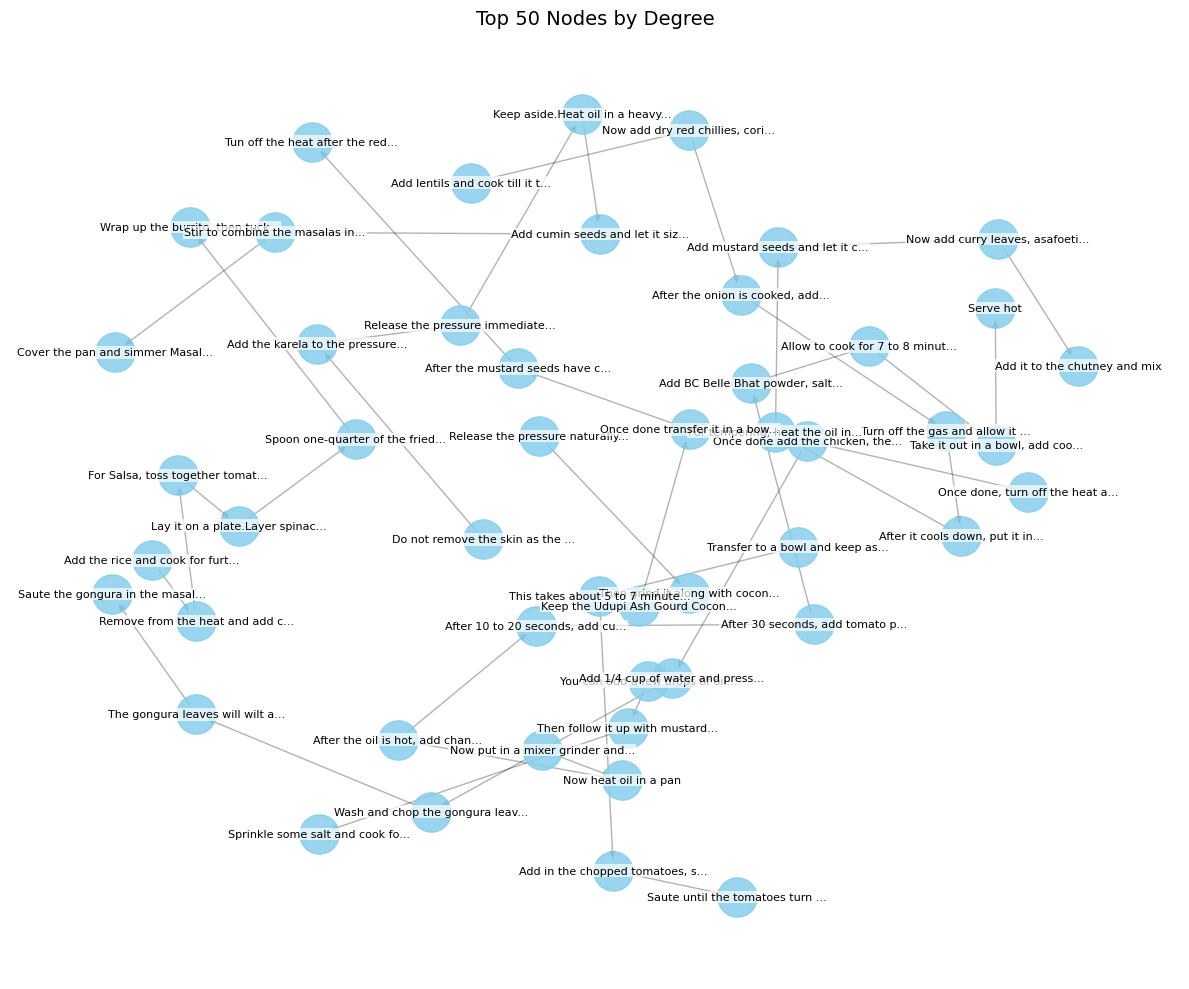

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# === SETTINGS ===
GRAPHML_PATH = "all_recipes.graphml"  # path to your combined graph
TOP_N = 50        # number of top-degree nodes to keep
TRUNCATE_LEN = 30 # max characters for labels
LAYOUT_K = 0.5    # spacing in spring layout

# === LOAD GRAPH ===
print("Loading graph...")
G_all = nx.read_graphml(GRAPHML_PATH)
print(f"Loaded graph with {G_all.number_of_nodes()} nodes and {G_all.number_of_edges()} edges")

# === FILTER: Top N nodes by degree ===
deg_sorted = sorted(G_all.degree, key=lambda x: x[1], reverse=True)
top_nodes = [n for n, _ in deg_sorted[:TOP_N]]
subG = G_all.subgraph(top_nodes).copy()
print(f"Subgraph: {subG.number_of_nodes()} nodes, {subG.number_of_edges()} edges")

# === CLEAN LABELS ===
labels = {}
for node, data in subG.nodes(data=True):
    txt = data.get("text", str(node))
    txt = txt.strip()
    if len(txt) > TRUNCATE_LEN:
        txt = txt[:TRUNCATE_LEN] + "..."
    labels[node] = txt

# === LAYOUT ===
pos = nx.spring_layout(subG, seed=42, k=LAYOUT_K)

# === DRAW ===
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(subG, pos, node_color="skyblue", node_size=800, alpha=0.85)
nx.draw_networkx_edges(subG, pos, alpha=0.3, width=1.0)
nx.draw_networkx_labels(
    subG, pos, labels=labels, font_size=8,
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1)
)

plt.title(f"Top {TOP_N} Nodes by Degree", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

### Building a multilingual ingredient network
This code creates a **graph connecting Hindi and English ingredient terms**:
- Tokenizes and cleans ingredient names.
- Uses **Dice similarity score** to find strong co-occurrence between Hindi and English words.
- Keeps top matches for each term.
- Builds a **bilingual network graph** where nodes are ingredients and edges represent likely translations.


In [21]:
import re
from collections import Counter, defaultdict
import pandas as pd
import networkx as nx

def tokenize_ingredients(s: str):
    if not isinstance(s, str):
        return []
    parts = re.split(r"[,\n;]+", s)
    toks = []
    for p in parts:
        t = p.strip().lower()
        t = re.sub(r"\d+.*", "", t)  # remove quantities
        t = re.sub(r"[\(\)\-/]", " ", t)
        t = re.sub(r"\s+", " ", t).strip()
        if t:
            toks.append(t)
    return toks

def dice_score(co, fa, fb):
    return 2 * co / (fa + fb) if (fa + fb) else 0

def build_multilingual_term_graph(df, col_hi="Ingredients", col_en="TranslatedIngredients",
                                  min_freq=2, top_k_per_term=5):
    fa = Counter()
    fb = Counter()
    co = Counter()
    for _, row in df.iterrows():
        a_terms = set(tokenize_ingredients(row.get(col_hi, "")))
        b_terms = set(tokenize_ingredients(row.get(col_en, "")))
        for a in a_terms:
            fa[a] += 1
        for b in b_terms:
            fb[b] += 1
        for a in a_terms:
            for b in b_terms:
                co[(a, b)] += 1

    edges = []
    for (a, b), c in co.items():
        if fa[a] < min_freq or fb[b] < min_freq:
            continue
        s = dice_score(c, fa[a], fb[b])
        edges.append((a, b, c, s))

    edges.sort(key=lambda x: x[3], reverse=True)
    top_by_a = defaultdict(list)
    for a, b, c, s in edges:
        if len(top_by_a[a]) < top_k_per_term:
            top_by_a[a].append((b, c, s))

    G = nx.Graph()
    for a in top_by_a:
        G.add_node(("hi", a), lang="hi", term=a)
        for b, c, s in top_by_a[a]:
            G.add_node(("en", b), lang="en", term=b)
            G.add_edge(("hi", a), ("en", b), weight=s, cooc=c)
    return G

### Running the multilingual graph builder
Here we:
- Load the dataset again.
- Build the Hindi–English ingredient graph.
- Save it as `out_multilingual_terms.graphml`.
- Print how many nodes (ingredients) and edges (connections) were created.


In [22]:
df = pd.read_csv("IndianFoodDatasetCSV.csv")
G_terms = build_multilingual_term_graph(df, min_freq=2, top_k_per_term=5)
nx.write_graphml(G_terms, "out_multilingual_terms.graphml")
print(f"Saved multilingual term network with {len(G_terms.nodes())} nodes and {len(G_terms.edges())} edges")

Saved multilingual term network with 1037 nodes and 1988 edges


In [23]:
import networkx as nx

print("Nodes:", G_terms.number_of_nodes())
print("Edges:", G_terms.number_of_edges())
print("Density:", nx.density(G_terms))
print("Is connected:", nx.is_connected(G_terms))
print("Number of connected components:", nx.number_connected_components(G_terms))

Nodes: 1037
Edges: 1988
Density: 0.0037009043759284837
Is connected: False
Number of connected components: 18


In [24]:
# Top nodes by degree
deg_sorted = sorted(G_terms.degree, key=lambda x: x[1], reverse=True)
print("Top 10 nodes by degree:")
for node, deg in deg_sorted[:10]:
    print("Node:",node,"||   Degree:", deg)

# Top nodes by weighted degree (sum of edge weights)
weighted_deg = G_terms.degree(weight="weight")
weighted_sorted = sorted(weighted_deg, key=lambda x: x[1], reverse=True)
print("\nTop 10 nodes by weighted degree:")
for node, wdeg in weighted_sorted[:10]:
    print("Node:",node,"||   Edge Weight:", wdeg)

Top 10 nodes by degree:
Node: ('en', 'salt to taste') ||   Degree: 187
Node: ('en', 'salt as per taste') ||   Degree: 37
Node: ('en', 'water as required') ||   Degree: 35
Node: ('en', 'salt and pepper to taste') ||   Degree: 32
Node: ('en', 'नमक स्वाद अनुसार') ||   Degree: 29
Node: ('en', 'salt as required') ||   Degree: 26
Node: ('en', 'sunflower oil for cooking') ||   Degree: 24
Node: ('en', 'sunflower oil as required') ||   Degree: 22
Node: ('en', 'black pepper powder to taste') ||   Degree: 20
Node: ('en', 'water as needed') ||   Degree: 17

Top 10 nodes by weighted degree:
Node: ('en', 'baked beans as needed') ||   Edge Weight: 3.854054054054054
Node: ('hi', 'baked beans as needed') ||   Edge Weight: 3.8540540540540538
Node: ('hi', 'sev for topping') ||   Edge Weight: 3.8540540540540538
Node: ('hi', 'whole wheat brown bread') ||   Edge Weight: 3.8540540540540538
Node: ('en', 'sev for topping') ||   Edge Weight: 3.8
Node: ('en', 'whole wheat brown bread') ||   Edge Weight: 3.8
Node

In [25]:
edges_sorted = sorted(G_terms.edges(data=True), key=lambda x: x[2].get("weight", 0), reverse=True)
print("Top 10 strongest connections:")
for u, v, data in edges_sorted[:10]:
    print(u, "<->", v, "weight:", data.get("weight"), "co-occurrences:", data.get("cooc"))

Top 10 strongest connections:
('hi', 'sunflower oil as required') <-> ('en', 'sunflower oil as required') weight: 1.0 co-occurrences: 232
('en', 'salt as required') <-> ('hi', 'salt as required') weight: 1.0 co-occurrences: 222
('en', 'water as required') <-> ('hi', 'water as required') weight: 1.0 co-occurrences: 183
('en', 'coriander dhania leaves few sprigs') <-> ('hi', 'coriander dhania leaves few sprigs') weight: 1.0 co-occurrences: 40
('hi', 'sunflower oil for cooking') <-> ('en', 'sunflower oil for cooking') weight: 1.0 co-occurrences: 177
('en', 'black pepper powder for seasoning') <-> ('hi', 'black pepper powder for seasoning') weight: 1.0 co-occurrences: 22
('en', 'coriander dhania leaves a small bunch finely chopped') <-> ('hi', 'coriander dhania leaves a small bunch finely chopped') weight: 1.0 co-occurrences: 24
('en', 'red chilli powder to taste') <-> ('hi', 'red chilli powder to taste') weight: 1.0 co-occurrences: 19
('hi', 'sunflower oil') <-> ('en', 'sunflower oil') we

C:\Users\Adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pyth

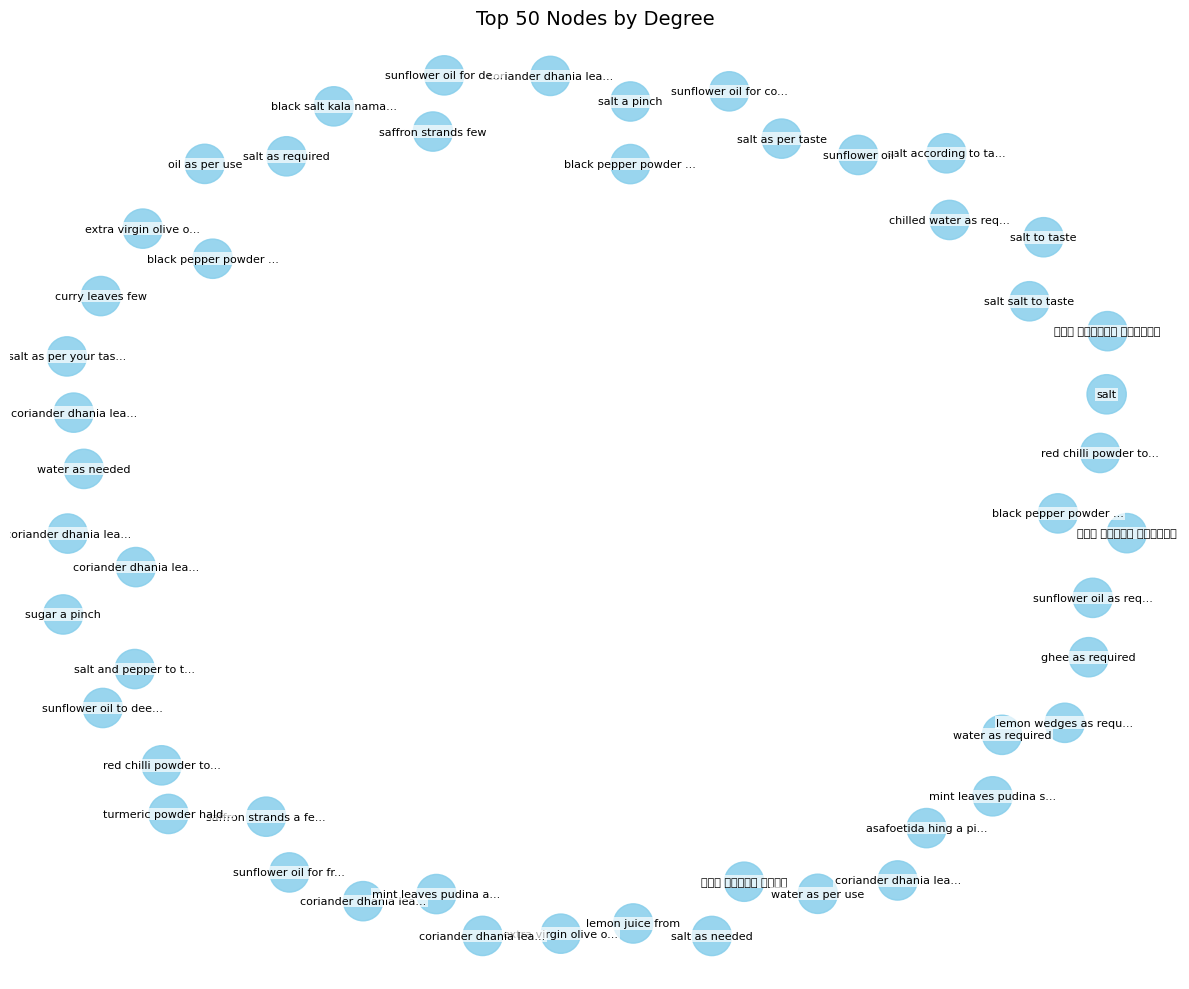

In [26]:
import matplotlib.pyplot as plt
import networkx as nx

# Make sure deg_sorted is built from G_terms
deg_sorted = sorted(G_terms.degree, key=lambda x: x[1], reverse=True)

# Take a subgraph of the top 50 nodes by degree
top_nodes = [n for n, _ in deg_sorted[:50]]
subG = G_terms.subgraph(top_nodes).copy()

# Bail out if subgraph is empty
if subG.number_of_nodes() == 0:
    raise ValueError("Subgraph is empty – check that top_nodes exist in G_terms")

# Layout with more spacing
pos = nx.spring_layout(subG, seed=42, k=0.7)

# Color nodes by language
colors = ["skyblue" if d.get("lang") == "en" else "lightcoral"
          for _, d in subG.nodes(data=True)]

# Shorten labels for readability
labels = {}
for node, data in subG.nodes(data=True):
    txt = data.get("term", str(node))
    if len(txt) > 20:
        txt = txt[:20] + "..."
    labels[node] = txt

# Draw
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(subG, pos, node_color=colors, node_size=800, alpha=0.85)
nx.draw_networkx_edges(subG, pos, alpha=0.3, width=1.0)
nx.draw_networkx_labels(
    subG, pos, labels=labels, font_size=8,
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1)
)

plt.title("Top 50 Nodes by Degree", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()